# Libraries

1) rasters comparison
2) differences mapping
3) area analysis

In [1]:
#libraries

import os
import pandas as pd
import numpy as np
import rasterio as rio
from itertools import product
from rasterio import windows
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns

from osgeo import gdal
from osgeo.gdalconst import GDT_Int16

# Helpers

In [8]:
def to_2d_array(x: np.ndarray)->np.ndarray: #misha grol functions
    return x.reshape(x.shape[0], x.shape[1] * x.shape[2])

def save_tif(raster_input:str, raster_output:str, values:np.array):
    in_data, out_data = None, None
    in_data = gdal.Open(raster_input)
    if in_data is None:
        print ('Unable to open %s' % raster_input)
    band1 = in_data.GetRasterBand(1)
    rows = in_data.RasterYSize
    cols = in_data.RasterXSize
    driver = in_data.GetDriver()
    out_data = driver.Create(raster_output, cols, rows, 1, GDT_Int16)
    dem_data = np.array(values)
    out_band = out_data.GetRasterBand(1)
    out_band.WriteArray(dem_data)
    out_band.FlushCache()
    out_band.SetNoDataValue(-1)

    out_data.SetGeoTransform(in_data.GetGeoTransform())
    out_data.SetProjection(in_data.GetProjection())
    del out_data
    return 'Map with changes is saved as GeoTIFF'

#turn classified raster to dataframe
def get_classified_data(raster:str):
    """
    Function takes path to the GeoTIFF raster file and return dataframe
    """
    with rio.open(raster, 'r+') as src:
        x = src.read()
        col_names = ['class']
        params = x[:len(x), ...]
        params = to_2d_array(x[:len(x), ...]) 
        df = pd.DataFrame(params.T, columns=col_names)
    return df

#get results of pixelwise comparasion of 2 rasters as df and as a map
def get_changes(raster1:str, raster2:str, return_change_map:bool=True):
    """
    Function takes two rasters and combines them. The outputs are dataframe with
    values from raster 1, values from raster 2, bool variable showing are they the same 
    or not, and new variable 'changed', which takes 0, if value in the same pixels of two 
    rasters are the same, and 1 if they are not
    """
    with rio.open(raster1, 'r+') as src:
        x = src.read()
    
    df1 = get_classified_data(raster1)
    df2 = get_classified_data(raster2)
    
    df = pd.DataFrame(df1['class'] == df2['class'])
    df['old_class'] = df1['class']
    df['new_class'] = df2['class']
    df['changed'] = df['class'].apply(lambda x: 0 if x==True else 1).astype('int16')

    if return_change_map is True:
        changes = df['changed']
        reclassified = changes.values
        forest_tile = reclassified.reshape((x.shape[1], x.shape[2]))
        output_mask=forest_tile
        raster_output = 'change_map.tif'
        status = save_tif(raster_input=fname, raster_output=raster_output, values=output_mask)
        print(status)
        return df
    else: return df

# Results example

In [3]:
fname = 'prediction_forest_rf.tif'
fname2 = 'prediction_forest_knn_worst.tif'

In [11]:
change_data=get_changes(fname, fname2, return_change_map=False) 
change_data

,class,old_class,new_class,changed
0,True,0,0,0
1,True,0,0,0
2,True,0,0,0
3,True,0,0,0
4,True,0,0,0
...,...,...,...,...
313231,True,0,0,0
313232,True,0,0,0
313233,True,0,0,0
313234,True,0,0,0


# Analysis and interpretation

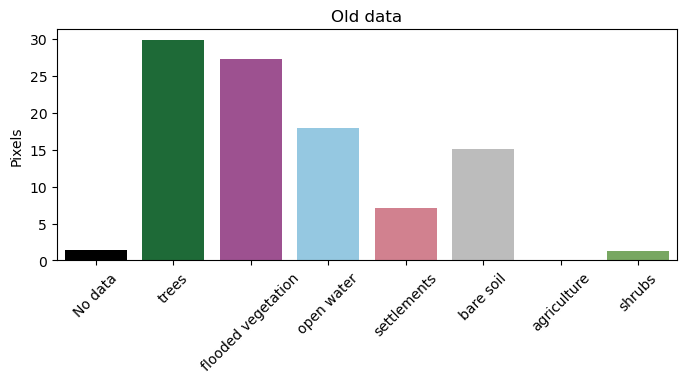

In [19]:
dict_normal_names = {0: 'No data',
                     1: 'trees', 
2: 'flooded vegetation',
3: 'open water',
4: 'settlements', 
5: 'bare soil',
6: 'agriculture', 
7: 'shrubs',
#8: 'grass'
}
data = change_data.groupby('old_class')['old_class'].agg({'count'}).reset_index()
data['percent'] = data['count'].apply(lambda x: x/sum(data['count'])*100)
data['names'] = data['old_class'].apply(lambda x: dict_normal_names[x])

colors =['black','#117733','#AA4499',  '#88CCEE', '#DE7486',
    '#bcbcbc',  '#F9CB9C', '#74b357' 
         
]

plt.figure(figsize=(8,3))
sns.barplot(data=data, x='names', y='percent', palette=colors)
plt.xlabel('')
plt.ylabel('Pixels')
plt.title('Old data')
plt.xticks(rotation=45)
#plt.savefig('Number_of_pixels.png', dpi = 300)
plt.show()

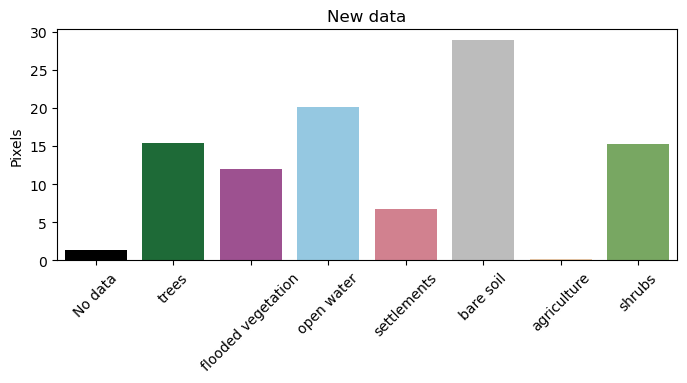

In [20]:
dict_normal_names = {0: 'No data',
                     1: 'trees', 
2: 'flooded vegetation',
3: 'open water',
4: 'settlements', 
5: 'bare soil',
6: 'agriculture', 
7: 'shrubs',
#8: 'grass'
}
data = change_data.groupby('new_class')['new_class'].agg({'count'}).reset_index()
data['percent'] = data['count'].apply(lambda x: x/sum(data['count'])*100)
data['names'] = data['new_class'].apply(lambda x: dict_normal_names[x])

colors =['black','#117733','#AA4499',  '#88CCEE', '#DE7486',
    '#bcbcbc',  '#F9CB9C', '#74b357' 
         
]

plt.figure(figsize=(8,3))
sns.barplot(data=data, x='names', y='percent', palette=colors)
plt.xlabel('')
plt.ylabel('Pixels')
plt.title('New data')
plt.xticks(rotation=45)
#plt.savefig('Number_of_pixels.png', dpi = 300)
plt.show()